In [6]:
from tensorflow import math
from keras.backend import softmax
from PIL import Image
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Layer,Dense

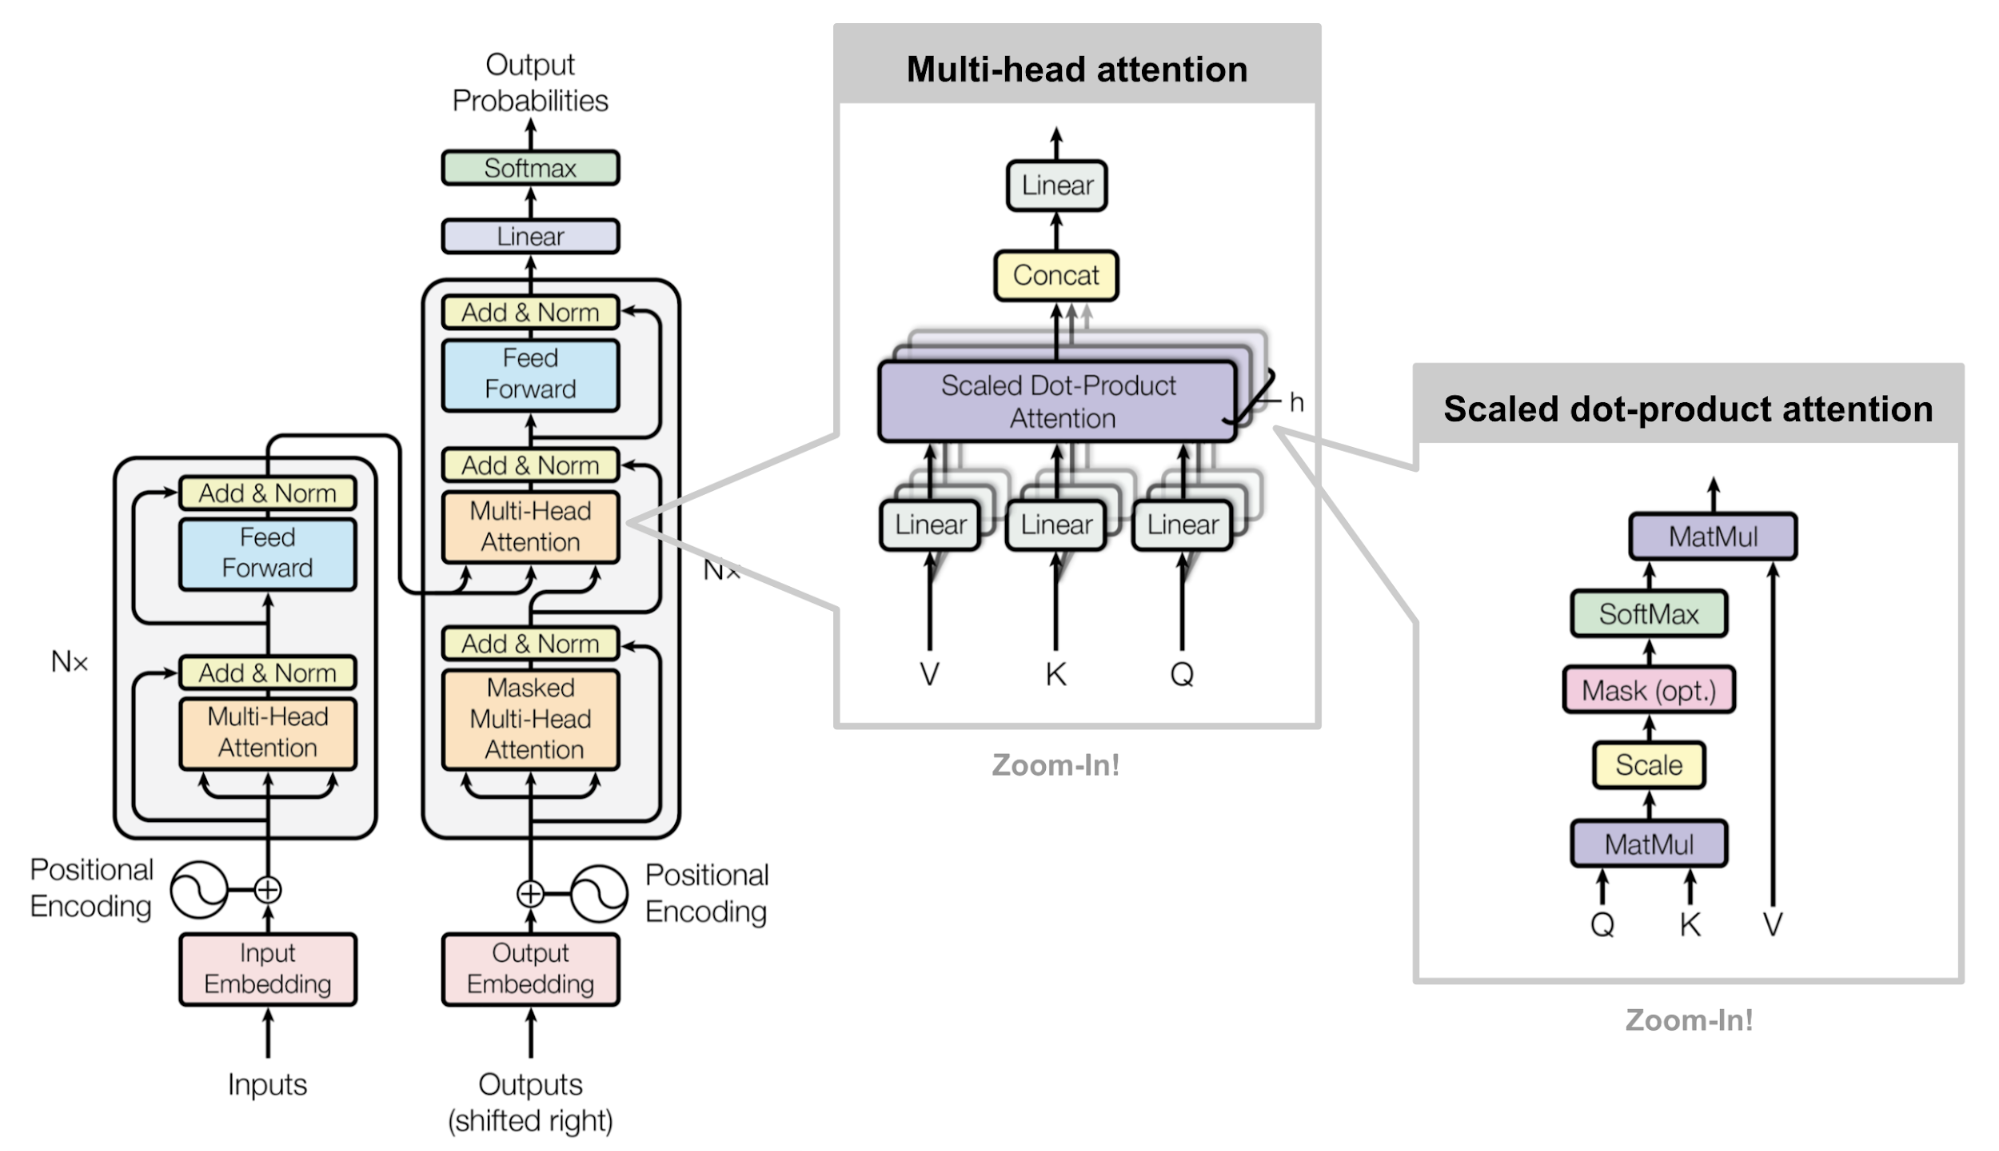

In [2]:
img =Image.open("img/transformer4.PNG") # because it is a PNG file
img = img.convert('RGB')
img

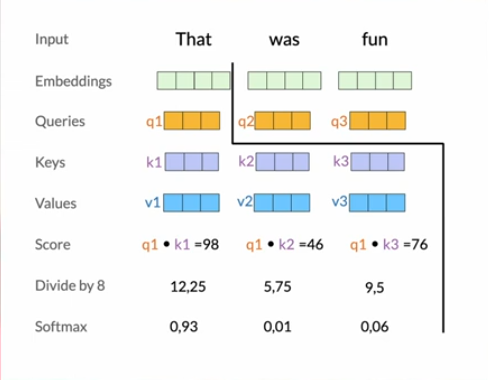

In [3]:
img =Image.open("img/transformer2.PNG") # because it is a PNG file
img = img.convert('RGB')
img

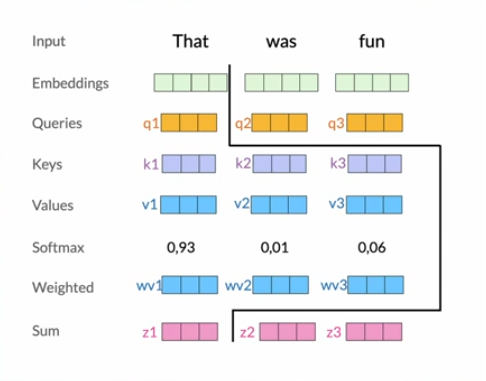

In [4]:
img =Image.open("img/transformer3.PNG") # because it is a PNG file
img = img.convert('RGB')
img

$$Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

### **Multihead attention**

In [5]:
from scale_dot import DotProductAttention

In [14]:
# Implementing the Multihead attention
class MultiHeadAttention(Layer):
    def __init__(self,h,d_k,d_v,d_model,**kwargs):
        super(MultiHeadAttention,self).__init__(**kwargs)
        # Scaled dot product attention
        self.attention = DotProductAttention()
        # Number of attention head to use
        self.heads = h 
        # Dimensionality of the linearly projected queries and keys
        self.d_k = d_k 
        # Dimensionality of the linearly projected values
        self.d_v = d_v
        # Dimensionality of the model
        self.d_model = d_model
        # Learned projection matrix for the queries
        self.W_q = Dense(d_k)
        # Learned projection matrix for the keys
        self.W_k = Dense(d_k)
        # Learned projection matrix for the values
        self.W_v = Dense(d_v)
        # Learned projection matrix for the multi-head output
        self.W_o = Dense(d_model)

    def reshape_tensor(self,x,heads,flag):
        if flag:
            # input tensor: (64,5,64)
            # queries = np.random.random((batch_size, input_seq_length, d_k))
            # Tensor shape after reshaping and transposing:
            # (batch_size,heads,seq_length, -1)
            # Reshaped into: (64,5,8,-1)
            x = tf.reshape(x,shape=(tf.shape(x)[0],tf.shape(x)[1],heads,-1))
            # Transposed into: (64,8,5,-1)
            x = tf.transpose(x, perm=(0,2,1,3))
        else:
            # Reverting the reshaping and transposing operations:
            # (batch_size,seq_length,d_k)
            # from (64,8,5,-1) Transposed into: (64,5,8,-1)
            x = tf.transpose(x, perm=(0,2,1,3))
            # Back into (64,5,64)
            x = tf.reshape(x,shape=(tf.shape(x)[0],tf.shape(x)[1],self.d_k))
        return x
    
    def call(self,queries, keys,values,mask=None):
        # Rearange the queries to be able to compute all heads in parallel
        # input queries: (64,5,64)
        q_reshaped = self.reshape_tensor(self.W_q(queries),self.heads,True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearange the keys to be able to compute all heads in parallel
        k_reshaped = self.reshape_tensor(self.W_k(keys),self.heads,True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)
        
        # Rearange the values to be able to compute all heads in parallel
        v_reshaped = self.reshape_tensor(self.W_v(values),self.heads,True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Compute the multi-head attention output 
        # using the reshaped queries, keys and values
        o_reshaped = self.attention(q_reshaped,
                                        k_reshaped,
                                        v_reshaped,
                                        self.d_k,
                                        mask)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)
        
        # Rearrange back the output into concatenated form
        output = self.reshape_tensor(o_reshaped,self.heads,False)
        # Resulting tensor shape: (batch_size, input_seq_length, d_v)

        # Apply one final linear projection to 
        # the output to generate the multi-head attention
        # Resulting tensor shape: (batch_size,input_seq_length, d_model)
        return self.W_o(output)

In [15]:
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_model = 512  # Dimensionality of the model sub-layers' outputs
batch_size = 64  # Batch size from the training process



input_seq_length = 5  # Maximum length of the input sequence
# (64,5,64)
queries = np.random.random((batch_size, input_seq_length, d_k))
keys = np.random.random((batch_size, input_seq_length, d_k))
values = np.random.random((batch_size, input_seq_length, d_v))


multihead_attention = MultiHeadAttention(h,d_k,d_v,d_model)
print("MultiHead Attention output:")
# Running this code produces an 
# output of shape (batch size, sequence length, model dimensionality). 
# (64,5,512)
multihead_attention(queries,keys,values) # 64 matrices, each 5x512

MultiHead Attention output:


<tf.Tensor: shape=(64, 5, 512), dtype=float32, numpy=
array([[[ 0.18340813,  0.26477128, -0.35152227, ...,  0.02674797,
          0.14310153,  0.21694507],
        [ 0.18564758,  0.2614927 , -0.3524853 , ...,  0.0265462 ,
          0.14614186,  0.21729843],
        [ 0.18353972,  0.26500282, -0.35724834, ...,  0.02761011,
          0.14079589,  0.21420836],
        [ 0.18561468,  0.26707152, -0.35495573, ...,  0.02942579,
          0.14555344,  0.2152932 ],
        [ 0.18303667,  0.2629278 , -0.35448548, ...,  0.02623313,
          0.14610332,  0.21514122]],

       [[ 0.13295142,  0.26849824, -0.34317183, ...,  0.01797199,
          0.23697312,  0.15245949],
        [ 0.13447008,  0.2685027 , -0.34443063, ...,  0.01838861,
          0.23664266,  0.15215865],
        [ 0.13472967,  0.26849762, -0.34531856, ...,  0.01800372,
          0.23428912,  0.15232073],
        [ 0.13437207,  0.26663712, -0.34623882, ...,  0.01754452,
          0.23603883,  0.15097259],
        [ 0.13484207,  0.2

In [16]:

# Create a sample tensor with shape (64, 5, 8, -1)
# For illustration purposes, let's assume the last dimension is 3, so the shape is (64, 5, 8, 3).
tensor_data = tf.random.normal((64, 5, 8, 3))

# Transpose the tensor using perm (0, 2, 1, 3)
transposed_tensor = tf.transpose(tensor_data, perm=[0, 2, 1, 3])

# Print the original and transposed tensor shapes
print("Original Tensor Shape:", tensor_data.shape)        # Output: (64, 5, 8, 3)
print("Transposed Tensor Shape:", transposed_tensor.shape)  

Original Tensor Shape: (64, 5, 8, 3)
Transposed Tensor Shape: (64, 8, 5, 3)


In [17]:
tensor_data

<tf.Tensor: shape=(64, 5, 8, 3), dtype=float32, numpy=
array([[[[ 4.29666042e-01,  1.54375732e+00,  6.63796127e-01],
         [-1.74460590e+00,  1.07459581e+00, -1.50988907e-01],
         [-1.02948213e+00,  5.56323230e-01, -4.17203963e-01],
         ...,
         [-1.16689932e+00,  1.94961214e+00, -1.70652807e+00],
         [-2.42985463e+00,  1.20846555e-01,  7.61536479e-01],
         [ 1.21266864e-01,  6.25770926e-01, -1.14519489e+00]],

        [[-5.45462333e-02, -1.17001545e+00, -1.24732137e+00],
         [ 9.48790133e-01,  3.56723785e-01,  1.16771281e+00],
         [ 1.75429702e-01,  3.44940931e-01,  8.15891683e-01],
         ...,
         [-2.49231625e+00, -3.92759502e-01, -8.69025946e-01],
         [-6.80476964e-01, -1.26480830e+00,  3.77541691e-01],
         [ 6.00433707e-01,  3.57580781e-01, -1.08947851e-01]],

        [[ 1.11504364e+00, -1.96260953e+00,  4.93170708e-01],
         [-1.28890550e+00,  5.23952544e-01, -1.60623121e+00],
         [-3.26133341e-01,  1.27487624e+00,  

In [18]:
transposed_tensor

<tf.Tensor: shape=(64, 8, 5, 3), dtype=float32, numpy=
array([[[[ 4.29666042e-01,  1.54375732e+00,  6.63796127e-01],
         [-5.45462333e-02, -1.17001545e+00, -1.24732137e+00],
         [ 1.11504364e+00, -1.96260953e+00,  4.93170708e-01],
         [ 2.47260475e+00, -3.70265126e+00,  3.51080865e-01],
         [ 1.65684140e+00,  1.13025165e+00,  7.11977243e-01]],

        [[-1.74460590e+00,  1.07459581e+00, -1.50988907e-01],
         [ 9.48790133e-01,  3.56723785e-01,  1.16771281e+00],
         [-1.28890550e+00,  5.23952544e-01, -1.60623121e+00],
         [-2.43358135e-01, -1.27809727e+00,  1.48895597e+00],
         [ 8.80749762e-01, -2.07527566e+00,  1.04245353e+00]],

        [[-1.02948213e+00,  5.56323230e-01, -4.17203963e-01],
         [ 1.75429702e-01,  3.44940931e-01,  8.15891683e-01],
         [-3.26133341e-01,  1.27487624e+00,  2.14554572e+00],
         [ 8.72846127e-01,  1.60196149e+00,  1.20154329e-01],
         [ 5.15761912e-01,  9.67387438e-01, -4.97874171e-01]],

        .